In [54]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from tqdm import tqdm

## Stocks Data

In [2]:
companies = ['Cap', 'Ele', 'Fin', 'FinEle']
input_path = 'Input'

In [3]:
def plot_nan(data, save_name, figsize=(10, 4), savefig=False):
    plt.figure(figsize=figsize)
    ax = sns.heatmap(data, cbar=False, cmap='binary')
    years = data.index.to_series().dt.year.unique()
    year_ticks = [data.index[data.index.to_series().dt.year == year][0] for year in years]
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=6, fontweight='bold')
    ax.set_yticks([data.index.get_loc(tick) for tick in year_ticks])
    ax.set_yticklabels(years, fontsize=8, fontweight='heavy')
    plt.xticks(rotation=90)
    for i in range(data.shape[1]):
        ax.vlines(i, ymin=0, ymax=data.shape[0], color='gray', linewidth=1)
    plt.tight_layout()
    if savefig:
        plt.savefig(f'{output_path}/{save_name}.png', dpi=144, transparent=True)
        plt.close()
    else:
        plt.show()

def nan_mask(data, window=128):
    nan_mask = data.isna()
    expanded_mask = nan_mask.rolling(window=window*2+1, min_periods=1, center=True).max()
    return expanded_mask

In [42]:
data = pd.read_csv(f'{input_path}/Stock return.csv', index_col='Date')
data.index.name = None
data.index = pd.to_datetime(data.index)
# data_mask = data.isna()
# data_mask = data_mask.rolling(window=127, min_periods=1, center=True).max()
classification = pd.read_csv(f'{input_path}/Company Classification.csv')
fin = pd.read_csv(f'{input_path}/Company_Finance.csv')
ele = pd.read_csv(f'{input_path}/Company_Electronic.csv')

In [43]:
for company in tqdm(companies, desc="Processing Companies"):
    # print(company)
    output_path = f'../01 Raw Data/{company}'

    if not os.path.exists(output_path):
        os.makedirs(output_path)

    capital = pd.read_excel(f'{input_path}/Capitalization.xlsx', header=2)
    capital = capital.transpose()
    capital.columns = capital.iloc[0]
    capital = capital.iloc[1:]
    capital.columns = [col.split(' ')[0] for col in capital.columns]
    capital = capital.apply(pd.to_numeric, errors='coerce')
    temp = capital.index[-1]
    capital = capital.reindex(pd.to_datetime(data.index))
    for col in capital.columns:
        capital[col] = capital[col].interpolate(method='linear', limit_area='inside')
    capital_temp = capital.loc[:temp].bfill()
    capital.loc[:temp] = capital_temp

    cap_mask = nan_mask(capital)
    capital = capital.where(~cap_mask.astype(bool), np.nan)
    cap_rank = capital.rank(ascending=False, axis=1)

    if company == 'FinEle':
        modify = True
        capital_fin = capital[capital.columns.intersection(classification[classification['Sector'] == 'Financial']['Code'].astype(str))]
        capital_ele = capital[capital.columns.intersection(classification[classification['Sector'] == 'Electronic']['Code'].astype(str))]
    elif company == 'Fin':
        modify = False
        capital = capital[capital.columns.intersection(classification[classification['Sector'] == 'Financial']['Code'].astype(str))]
    elif company == 'Ele':
        modify = False
        capital = capital[capital.columns.intersection(classification[classification['Sector'] == 'Electronic']['Code'].astype(str))]
    elif company == 'Cap':
        modify = False

    top = 20

    if modify == True:
        top2 = int(top/(modify+1))
        top_company_fin = pd.DataFrame(index=capital.index, columns=range(1, top2+1))
        for date in capital_fin.index:
            date_top_company = capital_fin.loc[date].nlargest(top2).index
            top_company_fin.loc[date] = date_top_company
        sum_top_company_fin = pd.unique(top_company_fin.values.ravel())

        top_company_ele = pd.DataFrame(index=capital.index, columns=range(1, top2+1))
        for date in capital_ele.index:
            date_top_company = capital_ele.loc[date].nlargest(top2).index
            top_company_ele.loc[date] = date_top_company
        sum_top_company_ele = pd.unique(top_company_ele.values.ravel())
        top_company = pd.concat([top_company_fin, top_company_ele], axis=1)
        top_company.columns = range(1, top+1)
        top_company = top_company.reindex(pd.to_datetime(data.index)).ffill().bfill()
        sum_top_company = np.concatenate((sum_top_company_fin,sum_top_company_ele))
    else:
        top_company = pd.DataFrame(index=capital.index, columns=range(1, top+1))
        for date in capital.index:
            date_top_company = capital.loc[date].nlargest(top).index                    # code of the top n companies in date
            top_company.loc[date] = date_top_company                                    # put them into cap_rank_company

        top_company = top_company.reindex(pd.to_datetime(data.index)).ffill().bfill()   # transform to daily data
        sum_top_company = pd.unique(top_company.values.ravel())
        
    sum_top_data = pd.DataFrame(data, columns=sum_top_company)
    sum_top_data = sum_top_data.reindex(columns=sum_top_company)

    select_company = pd.DataFrame(False, index=sum_top_data.index, columns=sum_top_data.columns)
    for date in top_company.index:
        for company in sum_top_data.loc[date].dropna().index:
            if company in top_company.loc[date].values:
                select_company.at[date, company] = True

    top_company.to_csv(f'{output_path}/Top rank company.csv', index=True, index_label='Date')
    sum_top_data.to_csv(f'{output_path}/Stock returns.csv', na_rep='', index=True, index_label='Date')
    select_company.to_csv(f'{output_path}/Selected company.csv', index=True, index_label='Date')

    plot_nan(sum_top_data.isna(), 'Stock Missing Data', savefig=True)
    plot_nan(select_company, 'Select Company', savefig=True)

Processing Companies: 100%|██████████| 4/4 [00:37<00:00,  9.33s/it]


## Macroeconomics Data

In [49]:
macro_original = pd.read_csv(f'{input_path}/Macro Original.csv', parse_dates=True, index_col='Date')

columns_order = ['TAIEX', 'Electronic', 'Financial', 'SP500', 'REITs', 'TW2Y', 'Slope', 'VIXTWN', 'USDTWD', 'ONIR']
macro_original = macro_original[columns_order]

columns = macro_original.columns
macro_corr = pd.DataFrame(index=columns, columns=columns, dtype=float)
macro_pvalue = pd.DataFrame(index=columns, columns=columns, dtype=float)

for i in columns:
    for j in columns:
        corr, pvalue = pearsonr(macro_original[i], macro_original[j])
        macro_corr.loc[i, j] = corr
        macro_pvalue.loc[i, j] = pvalue

def significance_symbol(p):
    if p <= 0.01:
        return '***'
    elif p <= 0.05:
        return '**'
    elif p <= 0.10:
        return '*'
    else:
        return ''

macro_corr_s = macro_corr.copy().astype(object)
for i in columns:
    for j in columns:
        if i == j:
            macro_corr_s.loc[i, j] = f"{macro_corr.loc[i, j]:.2f}"
        else:
            symbol = significance_symbol(macro_pvalue.loc[i, j])
            macro_corr_s.loc[i, j] = f"{macro_corr.loc[i, j]:.2f}{symbol}"

macro_corr_s

,TAIEX,Electronic,Financial,SP500,REITs,TW2Y,Slope,VIXTWN,USDTWD,ONIR
TAIEX,1.00,0.96***,0.84***,0.17***,0.28***,0.00,0.10***,-0.51***,-0.45***,-0.03*
Electronic,0.96***,1.00,0.71***,0.16***,0.26***,-0.00,0.09***,-0.49***,-0.42***,-0.03*
Financial,0.84***,0.71***,1.00,0.13***,0.27***,0.01,0.08***,-0.39***,-0.38***,-0.02
SP500,0.17***,0.16***,0.13***,1.00,0.02,0.00,0.11***,-0.10***,-0.10***,0.02
REITs,0.28***,0.26***,0.27***,0.02,1.00,0.00,0.15***,-0.13***,-0.16***,-0.01
TW2Y,0.00,-0.00,0.01,0.00,0.00,1.00,-0.04**,-0.01,0.03**,0.01
Slope,0.10***,0.09***,0.08***,0.11***,0.15***,-0.04**,1.00,-0.01,-0.05***,-0.01
VIXTWN,-0.51***,-0.49***,-0.39***,-0.10***,-0.13***,-0.01,-0.01,1.00,0.22***,-0.02
USDTWD,-0.45***,-0.42***,-0.38***,-0.10***,-0.16***,0.03**,-0.05***,0.22***,1.00,-0.02
ONIR,-0.03*,-0.03*,-0.02,0.02,-0.01,0.01,-0.01,-0.02,-0.02,1.00


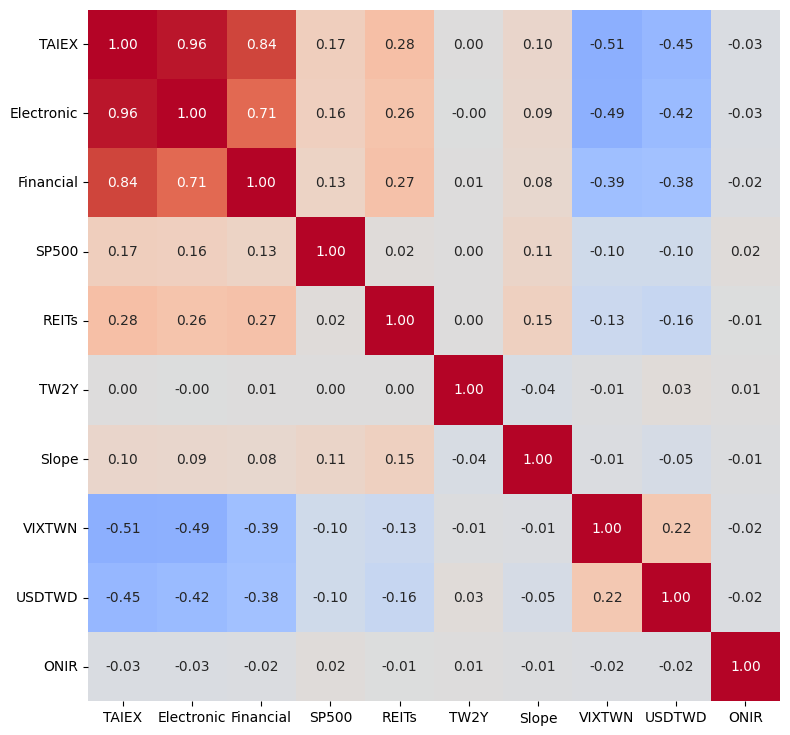

In [50]:
plt.figure(figsize=(8, 8))
sns.heatmap(macro_corr, annot=True, fmt=".2f", cmap='coolwarm', center=0, cbar=False)
plt.tight_layout()
plt.xticks(rotation=0)
# plt.savefig('heatmap.png', transparent=True, dpi=144)
plt.show()

In [ ]:
output_path = f'../01 Raw Data/Macro'

if not os.path.exists(output_path):
    os.makedirs(output_path)

macro = macro_original[['TAIEX', 'VIXTWN', 'TW2Y', 'ONIR']]
macro.to_csv(f'{output_path}/macro.csv')
macro

,TAIEX,VIXTWN,TW2Y,ONIR
Date,,,,
2006-12-04,0.004383,0.148592,0.002102,-0.000603
2006-12-05,-0.004865,-0.042456,0.000700,-0.002414
2006-12-06,0.010904,-0.077180,0.000699,0.001811
2006-12-07,-0.000886,0.047841,0.000699,0.000000
2006-12-08,-0.006555,0.072273,0.000000,-0.000603
...,...,...,...,...
2023-12-25,0.000466,0.005074,0.009804,-0.002928
2023-12-26,0.008309,-0.018242,-0.009804,0.000000
2023-12-27,0.007843,0.015346,0.000000,0.002928


## Others Data

In [56]:
input_files = [f'{input_path}/MI.csv', f'{input_path}/VIXTWN.csv']
output_path = '../01 Raw Data/Others'

if not os.path.exists(output_path):
    os.makedirs(output_path)

for file in input_files:
    if os.path.exists(file):
        shutil.copy(file, output_path)
    else:
        print(f"File '{file}' does not exist.")